# Imports

In [1]:
import math
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
mpl.rcParams.update(mpl.rcParamsDefault) # reset matplotlib theming
plt.style.use("dark_background")

# Helper Functions

In [2]:
def multiplyLTIs(h1, h2):
    numerator = (np.poly1d(h1.num) * np.poly1d(h2.num)).coefficients
    denominator = (np.poly1d(h1.den) * np.poly1d(h2.den)).coefficients
    return signal.lti(numerator, denominator)

In [3]:
def ltiInfo(h, evaluate_extra=False):
    # zeros, poles, DC gain
    zpk = h.to_zpk()
    print("zeros: ", ", ".join(map(lambda z: "%.3g" % z, zpk.zeros / (2 * math.pi))))
    print("poles: ", ", ".join(map(lambda p: "%.3g" % p, zpk.poles / (2 * math.pi))))
    dc_gain = 20 * np.log10(h.num[-1] / h.den[-1])
    print("DC gain: %.3g [dB]" % dc_gain)

    if evaluate_extra:
        # evaluate magnitude & phase @ 20/1k/10k/20k Hz
        for f in [20, 1e3, 10e3, 20e3]:
            w = 2 * math.pi * f
            _, mag, phase = h.bode([w])
            print("Magnitude @ %.3g Hz: %.3g [dB]" % (f, mag))
            print("Phase @ %.3g Hz: %.2g [deg]" % (f, phase))

In [4]:
def readLTspiceSim(filepath):
    simout = []
    with open(filepath, "r", encoding="ISO-8859-1") as f:
        for line in f.readlines()[1:]:
            freq, mag_phase = line.strip().split("\t")
            mag, phase = mag_phase[1:-2].split("dB,")
            simout.append((float(freq), float(mag), float(phase)))
    return simout

In [5]:
def ltiPlot(h, extra_plot=None):
    fs_to_calc = np.array(list(filter(lambda n: n < 5.5e6, np.logspace(0, 7, 100))))
    # NOTE: signal.bode operates in radians
    # scale to angular frequency w = 2*pi*f
    ws_to_calc = 2 * math.pi * fs_to_calc
    
    # get bode plot params
    w, mag, phase = h.bode(ws_to_calc)
    # scale back to non-angular frequency w = 2*pi*f
    f = w / (2 * math.pi)

    # plot the magnitude plot
    fig, ax1 = plt.subplots(figsize=(14.5,8), facecolor="black")
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Amplitude [dB]")
    ax1.semilogx(f, mag, linewidth=3.0, c="y")
    ax1.grid()

    # plot the phase plot
    ax2 = ax1.twinx()
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Phase [deg]")
    ax2.semilogx(f, phase, linewidth=3.0, c="y", dashes=[5, 5])
    
    if extra_plot:
        sim_f = list(map(lambda t: t[0], extra_plot))
        sim_mag = list(map(lambda t: t[1], extra_plot))
        sim_phase = list(map(lambda t: t[2], extra_plot))
        ax1.semilogx(sim_f, sim_mag, linewidth=3.0, c="c")
        ax2.semilogx(sim_f, sim_phase, linewidth=3.0, c="c", dashes=[5, 5])

# Circuit Description

### $$\frac{V_o}{V_i} \; = \; \bigg(\frac{V_+}{V_i}\bigg) \bigg(\frac{V_o}{V_-}\bigg)$$

In [6]:
def getInputIR(R1, R2, C1):
    numerator = [R1]
    denominator = [C1*R1*R2, R1+R2]
    return signal.lti(numerator, denominator)

### $$\bigg(\frac{V_+}{V_i}\bigg) \; = \; \frac{Z_1}{Z_1 + R_2}$$

$$\; = \; \frac{1}{1 + \frac{R_2}{Z_1}}$$

$$= \; \frac{1}{1 + R_2({C_1}s + \frac{1}{R_1})}$$

### $$= \; \frac{R_1}{{C_1}{R_1}{R_2}s + (R_1 + R_2)}$$

In [7]:
def getFeedbackIR(R3, R4, C3, C4):
    numerator = [(C3+C4)*R3*R4, R3+R4]
    denominator = [C4*R3*R4, R3]
    return signal.lti(numerator, denominator)

### $$\bigg(\frac{V_o}{V_-}\bigg) = \frac{Z_3 + Z_4}{Z_3}$$

$$\; = \; \frac{\frac{1}{Z_4} + \frac{1}{Z_3}}{\frac{1}{Z_4}}$$

$$\; = \; \frac{({C_4}s + \frac{1}{R_4}) + ({C_3}s + \frac{1}{R_3})}{({C_4}s + \frac{1}{R_4})}$$

### $$\; = \; \frac{(C_3 + C_4){R_3}{R_4}s + (R_3 + R_4)}{{C_4}{R_3}{R_4}s + R_3}$$

# Default Config Simulations

In [8]:
default_plus = getInputIR(R1=10e3, R2=274, C1=220e-12)
ltiInfo(default_plus)

zeros:  
poles:  -2.71e+06
DC gain: -0.235 [dB]


### High Gain

In [9]:
default_minus_high_gain = getFeedbackIR(R3=274, R4=1.5e3, C3=3e-12, C4=220e-12)
ltiInfo(default_minus_high_gain)

zeros:  -3.08e+06
poles:  -4.82e+05
DC gain: 16.2 [dB]


zeros:  -3.08e+06
poles:  -2.71e+06, -4.82e+05
DC gain: 16 [dB]
Magnitude @ 20 Hz: 16 [dB]
Phase @ 20 Hz: -0.0024 [deg]
Magnitude @ 1e+03 Hz: 16 [dB]
Phase @ 1e+03 Hz: -0.12 [deg]
Magnitude @ 1e+04 Hz: 16 [dB]
Phase @ 1e+04 Hz: -1.2 [deg]
Magnitude @ 2e+04 Hz: 16 [dB]
Phase @ 2e+04 Hz: -2.4 [deg]


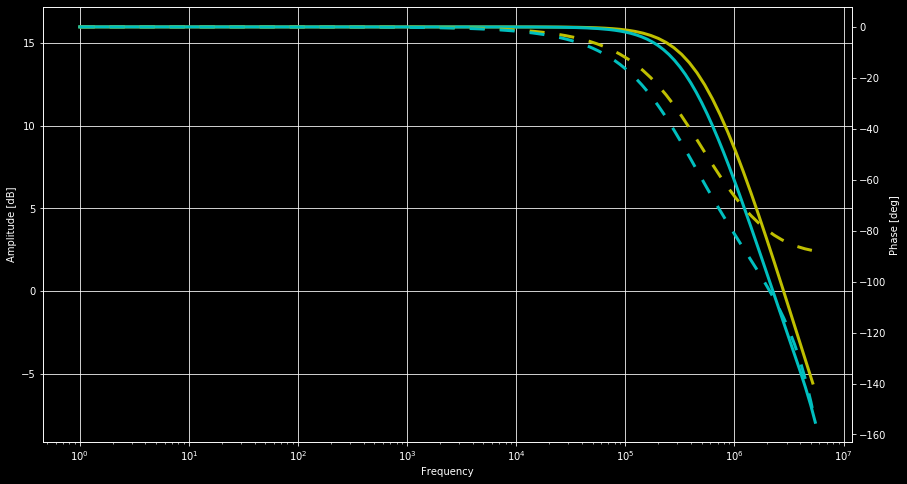

In [10]:
default_high_gain = multiplyLTIs(default_plus, default_minus_high_gain)
ltiInfo(default_high_gain, evaluate_extra=True)
ltiPlot(default_high_gain, extra_plot=readLTspiceSim("O2_NJM2068_HighGain.txt"))

### Low Gain

In [11]:
default_minus_low_gain = getFeedbackIR(R3=1e3, R4=1.5e3, C3=3e-12, C4=220e-12)
ltiInfo(default_minus_low_gain)

zeros:  -1.19e+06
poles:  -4.82e+05
DC gain: 7.96 [dB]


zeros:  -1.19e+06
poles:  -2.71e+06, -4.82e+05
DC gain: 7.72 [dB]
Magnitude @ 20 Hz: 7.72 [dB]
Phase @ 20 Hz: -0.0018 [deg]
Magnitude @ 1e+03 Hz: 7.72 [dB]
Phase @ 1e+03 Hz: -0.092 [deg]
Magnitude @ 1e+04 Hz: 7.72 [dB]
Phase @ 1e+04 Hz: -0.92 [deg]
Magnitude @ 2e+04 Hz: 7.72 [dB]
Phase @ 2e+04 Hz: -1.8 [deg]


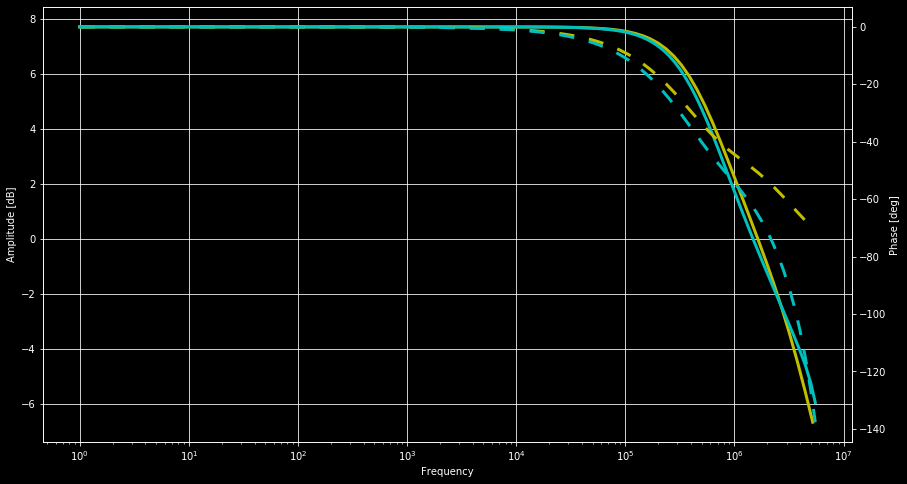

In [12]:
default_low_gain = multiplyLTIs(default_plus, default_minus_low_gain)
ltiInfo(default_low_gain, evaluate_extra=True)
ltiPlot(default_low_gain, extra_plot=readLTspiceSim("O2_NJM2068_LowGain.txt"))

# Modified Config Simulations

In [13]:
# Gain
# Normal DAC / pre-amplifier output: 1Vrms = +/-1.4V
# HD650/HD6XX: 115 dB SPL peak @ 4Vrms = +/-5.66V
# with excess gain, aim for 6X => 6Vrms = +/-8.5V

# RF Filter

# TODO: update ltiInfo with Magnitude/Phase @ 20/1k/10k/20k

In [14]:
mod_plus = getInputIR(R1=20e3, R2=750, C1=82e-12)
ltiInfo(mod_plus)

zeros:  
poles:  -2.68e+06
DC gain: -0.32 [dB]


### High Gain

In [15]:
mod_minus_high_gain = getFeedbackIR(R3=750, R4=4020, C3=3e-12, C4=82e-12)
ltiInfo(mod_minus_high_gain)

zeros:  -2.96e+06
poles:  -4.83e+05
DC gain: 16.1 [dB]


zeros:  -2.96e+06
poles:  -2.68e+06, -4.83e+05
DC gain: 15.7 [dB]
Magnitude @ 20 Hz: 15.7 [dB]
Phase @ 20 Hz: -0.0024 [deg]
Magnitude @ 1e+03 Hz: 15.7 [dB]
Phase @ 1e+03 Hz: -0.12 [deg]
Magnitude @ 1e+04 Hz: 15.7 [dB]
Phase @ 1e+04 Hz: -1.2 [deg]
Magnitude @ 2e+04 Hz: 15.7 [dB]
Phase @ 2e+04 Hz: -2.4 [deg]


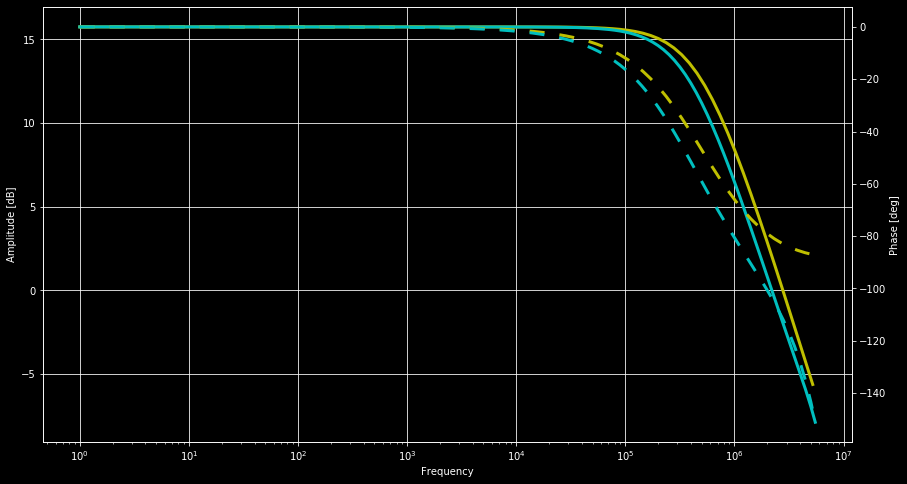

In [16]:
mod_high_gain = multiplyLTIs(mod_plus, mod_minus_high_gain)
ltiInfo(mod_high_gain, evaluate_extra=True)
ltiPlot(mod_high_gain, extra_plot=readLTspiceSim("Mod_NJM2068_HighGain.txt"))

### Low Gain

In [17]:
mod_minus_low_gain = getFeedbackIR(R3=3240, R4=4020, C3=3e-12, C4=82e-12)
ltiInfo(mod_minus_low_gain)

zeros:  -1.04e+06
poles:  -4.83e+05
DC gain: 7.01 [dB]


zeros:  -1.04e+06
poles:  -2.68e+06, -4.83e+05
DC gain: 6.69 [dB]
Magnitude @ 20 Hz: 6.69 [dB]
Phase @ 20 Hz: -0.0017 [deg]
Magnitude @ 1e+03 Hz: 6.69 [dB]
Phase @ 1e+03 Hz: -0.085 [deg]
Magnitude @ 1e+04 Hz: 6.69 [dB]
Phase @ 1e+04 Hz: -0.85 [deg]
Magnitude @ 2e+04 Hz: 6.68 [dB]
Phase @ 2e+04 Hz: -1.7 [deg]


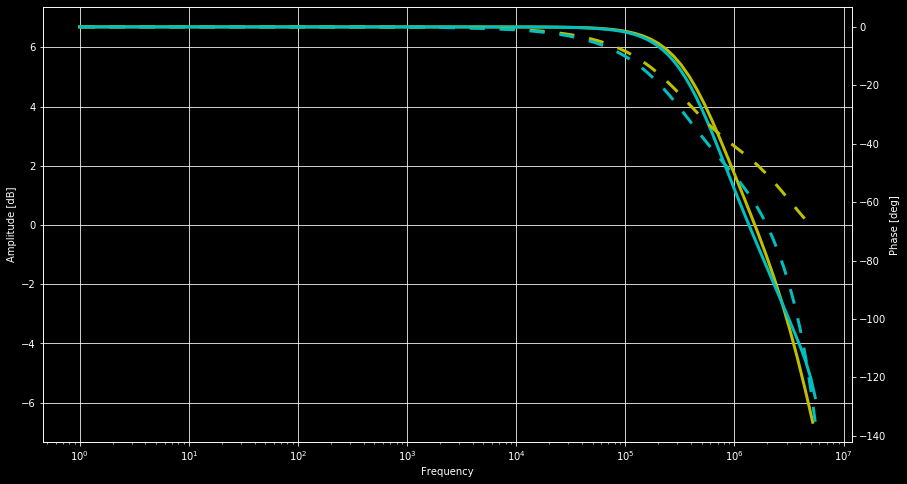

In [18]:
mod_low_gain = multiplyLTIs(mod_plus, mod_minus_low_gain)
ltiInfo(mod_low_gain, evaluate_extra=True)
ltiPlot(mod_low_gain, extra_plot=readLTspiceSim("Mod_NJM2068_LowGain.txt"))